In [1]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train_err  = pd.read_csv('train_err_data.csv')
id_error = train_err[['user_id','errtype']].values
error = np.zeros((15000,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 10000,err - 1] += 1

train_prob = pd.read_csv('train_problem_data.csv')
problem = np.zeros(15000)
problem[train_prob.user_id.unique()-10000] = 1 

train = pd.DataFrame(data=error)
train['problem'] = problem
del error, problem
train['problem'] = train['problem'].astype('category')
clf = setup(data = train, target = 'problem')


Setup Succesfully Completed!


,Description,Value
0,session_id,8822
1,Target Type,Binary
2,Label Encoded,"0.0: 0, 1.0: 1"
3,Original Data,"(15000, 43)"
4,Missing Values,False
5,Numeric Features,42
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [3]:
train

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,problem
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,...,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,1.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,...,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,1.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0


In [4]:
train['problem'].value_counts()

0.0    10000
1.0     5000
Name: problem, dtype: int64

In [5]:
train

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,problem
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,...,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0,1.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,...,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,5.0,1.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0


In [6]:
'''
a = [9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 25, 29, 30, 33, 34, 5, 39]
b=[]
for i in range(42):
    if i not in a:
        b.append(str(i))
train=train.drop(b,axis=1)
train
'''

'\na = [9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 25, 29, 30, 33, 34, 5, 39]\nb=[]\nfor i in range(42):\n    if i not in a:\n        b.append(str(i))\ntrain=train.drop(b,axis=1)\ntrain\n'

In [7]:
del train['0']

In [8]:
from pycaret.classification import *
best_5 = compare_models(sort = 'Accuracy', n_select = 6)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.7831,0.8078,0.4877,0.7799,0.5996,0.4616,0.4858,8.5785
1,Gradient Boosting Classifier,0.7802,0.8025,0.4566,0.7986,0.5805,0.4462,0.4785,2.1543
2,Light Gradient Boosting Machine,0.7795,0.8022,0.4966,0.7597,0.6001,0.4570,0.4770,0.3121
3,Extra Trees Classifier,0.7782,0.7966,0.4854,0.7626,0.5930,0.4508,0.4726,0.5635
4,Extreme Gradient Boosting,0.7733,0.7902,0.5243,0.7197,0.6063,0.4527,0.4641,0.8528
5,Ada Boost Classifier,0.7719,0.7876,0.4551,0.7656,0.5706,0.4288,0.4558,0.7960
6,Random Forest Classifier,0.7580,0.7667,0.4429,0.7242,0.5493,0.3969,0.4194,0.1183
7,Linear Discriminant Analysis,0.7469,0.7392,0.3197,0.8023,0.4570,0.3298,0.3892,0.0616
8,Ridge Classifier,0.7459,0.0000,0.3123,0.8070,0.4501,0.3247,0.3866,0.0253
9,Quadratic Discriminant Analysis,0.7329,0.7375,0.2980,0.7475,0.4247,0.2917,0.3441,0.0504


In [9]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7738,0.7976,0.4886,0.7451,0.5902,0.4431,0.4620
1,0.7948,0.8269,0.5229,0.7905,0.6294,0.4955,0.5158
2,0.7843,0.7932,0.4671,0.8034,0.5908,0.4579,0.4890
3,0.7862,0.8161,0.4900,0.7885,0.6044,0.4686,0.4935
4,0.7866,0.8012,0.4871,0.7930,0.6035,0.4687,0.4947
Mean,0.7851,0.8070,0.4911,0.7841,0.6037,0.4668,0.4910
SD,0.0067,0.0126,0.0179,0.0202,0.0142,0.0171,0.0172


In [10]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7763,0.8058,0.4727,0.7665,0.5847,0.4432,0.4674


In [11]:
final_model = finalize_model(blended)

In [12]:
test_err  = pd.read_csv('test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)

100%|██████████████████████████████████████████████████████████████████| 16532648/16532648 [00:56<00:00, 292298.61it/s]


In [13]:
predictions = predict_model(final_model, data = test)

In [14]:
'''
x = []
for i in range(len(predictions['Score'])):
    if predictions['Label'][i] =='1.0':
        x.append(predictions['Score'][i])
    else:
        x.append(1-predictions['Score'][i])

'''

"\nx = []\nfor i in range(len(predictions['Score'])):\n    if predictions['Label'][i] =='1.0':\n        x.append(predictions['Score'][i])\n    else:\n        x.append(1-predictions['Score'][i])\n\n"

In [15]:
sample_submssion = pd.read_csv('sample_submission.csv')
sample_submssion['problem'] = predictions['Score']
sample_submssion.to_csv("AutoML.csv", index = False)

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
from sklearn import tree
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
train_2 = train.drop('problem',axis=1)
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)

clf = clf.fit(train_2, train['problem'])
X_train, X_test, Y_train, Y_test = train_test_split(train_2, train['problem'], test_size=0.3)
clf.fit(X_train,Y_train)
print(round(clf.score(X_test,Y_test),2)*100,"%")
print("특성 중요도 : \n{}".format(clf.feature_importances_))
print(clf.feature_importances_)
list(train_2.columns.array)


imp = clf.feature_importances_
if platform.system() == 'Windows':
    font_name= font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:
    rc('font', family='AppleGothic')

76.0 %
특성 중요도 : 
[0.         0.         0.01468106 0.00243131 0.         0.
 0.         0.         0.         0.         0.         0.00548977
 0.03261243 0.02150451 0.03946748 0.00302324 0.57838698 0.
 0.         0.00366716 0.         0.         0.         0.
 0.01289418 0.         0.         0.         0.05963901 0.12994698
 0.         0.00250843 0.03737299 0.05637447 0.         0.
 0.         0.         0.         0.         0.        ]
[0.         0.         0.01468106 0.00243131 0.         0.
 0.         0.         0.         0.         0.         0.00548977
 0.03261243 0.02150451 0.03946748 0.00302324 0.57838698 0.
 0.         0.00366716 0.         0.         0.         0.
 0.01289418 0.         0.         0.         0.05963901 0.12994698
 0.         0.00250843 0.03737299 0.05637447 0.         0.
 0.         0.         0.         0.         0.        ]


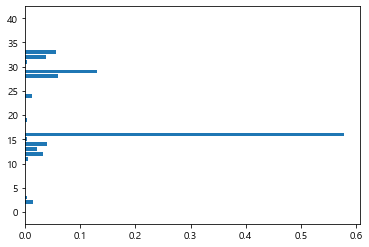

In [17]:
plt.barh(range(len(imp)), imp) 
#plt.yticks(range(len(imp)), list(df.columns.array)) 
plt.show()

In [18]:
a=imp.tolist()
for i in range(0,len(a)):
    
    print(str(i) , a[i])

0 0.0
1 0.0
2 0.014681060330929668
3 0.0024313063229166494
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.005489767448361519
12 0.03261243086918434
13 0.02150451076241729
14 0.03946748470470968
15 0.0030232414983770014
16 0.5783869847434
17 0.0
18 0.0
19 0.0036671571769938973
20 0.0
21 0.0
22 0.0
23 0.0
24 0.012894179666149962
25 0.0
26 0.0
27 0.0
28 0.059639012604735295
29 0.12994697653976306
30 0.0
31 0.002508432545599944
32 0.037372986498764464
33 0.056374468287697155
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
